In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

🚀 Iniciando análise completa do RoboCup 2.0...
📁 Estrutura detectada: Train/Valid/Test splits
🔍 Analisando todos os splits do dataset COCO...
--------------------------------------------------
✅ TRAIN : 34449 imagens, 136252 anotações, 18 classes
✅ VALID : 1726 imagens,  7012 anotações, 18 classes
✅ TEST  :  606 imagens,  2304 anotações, 18 classes

✅ Análise concluída! Dataset possui 19 classes: ['Axis2-Bearing2-Housing-Motor2-FRQP', 'AllenKey', 'Axis2', 'Bearing2', 'Drill', 'F20_20_B', 'F20_20_G', 'Housing', 'M20', 'M20_100', 'M30', 'Motor2', 'S40_40_B', 'S40_40_G', 'Screwdriver', 'Spacer', 'Wrench', 'container_box_blue', 'container_box_red']


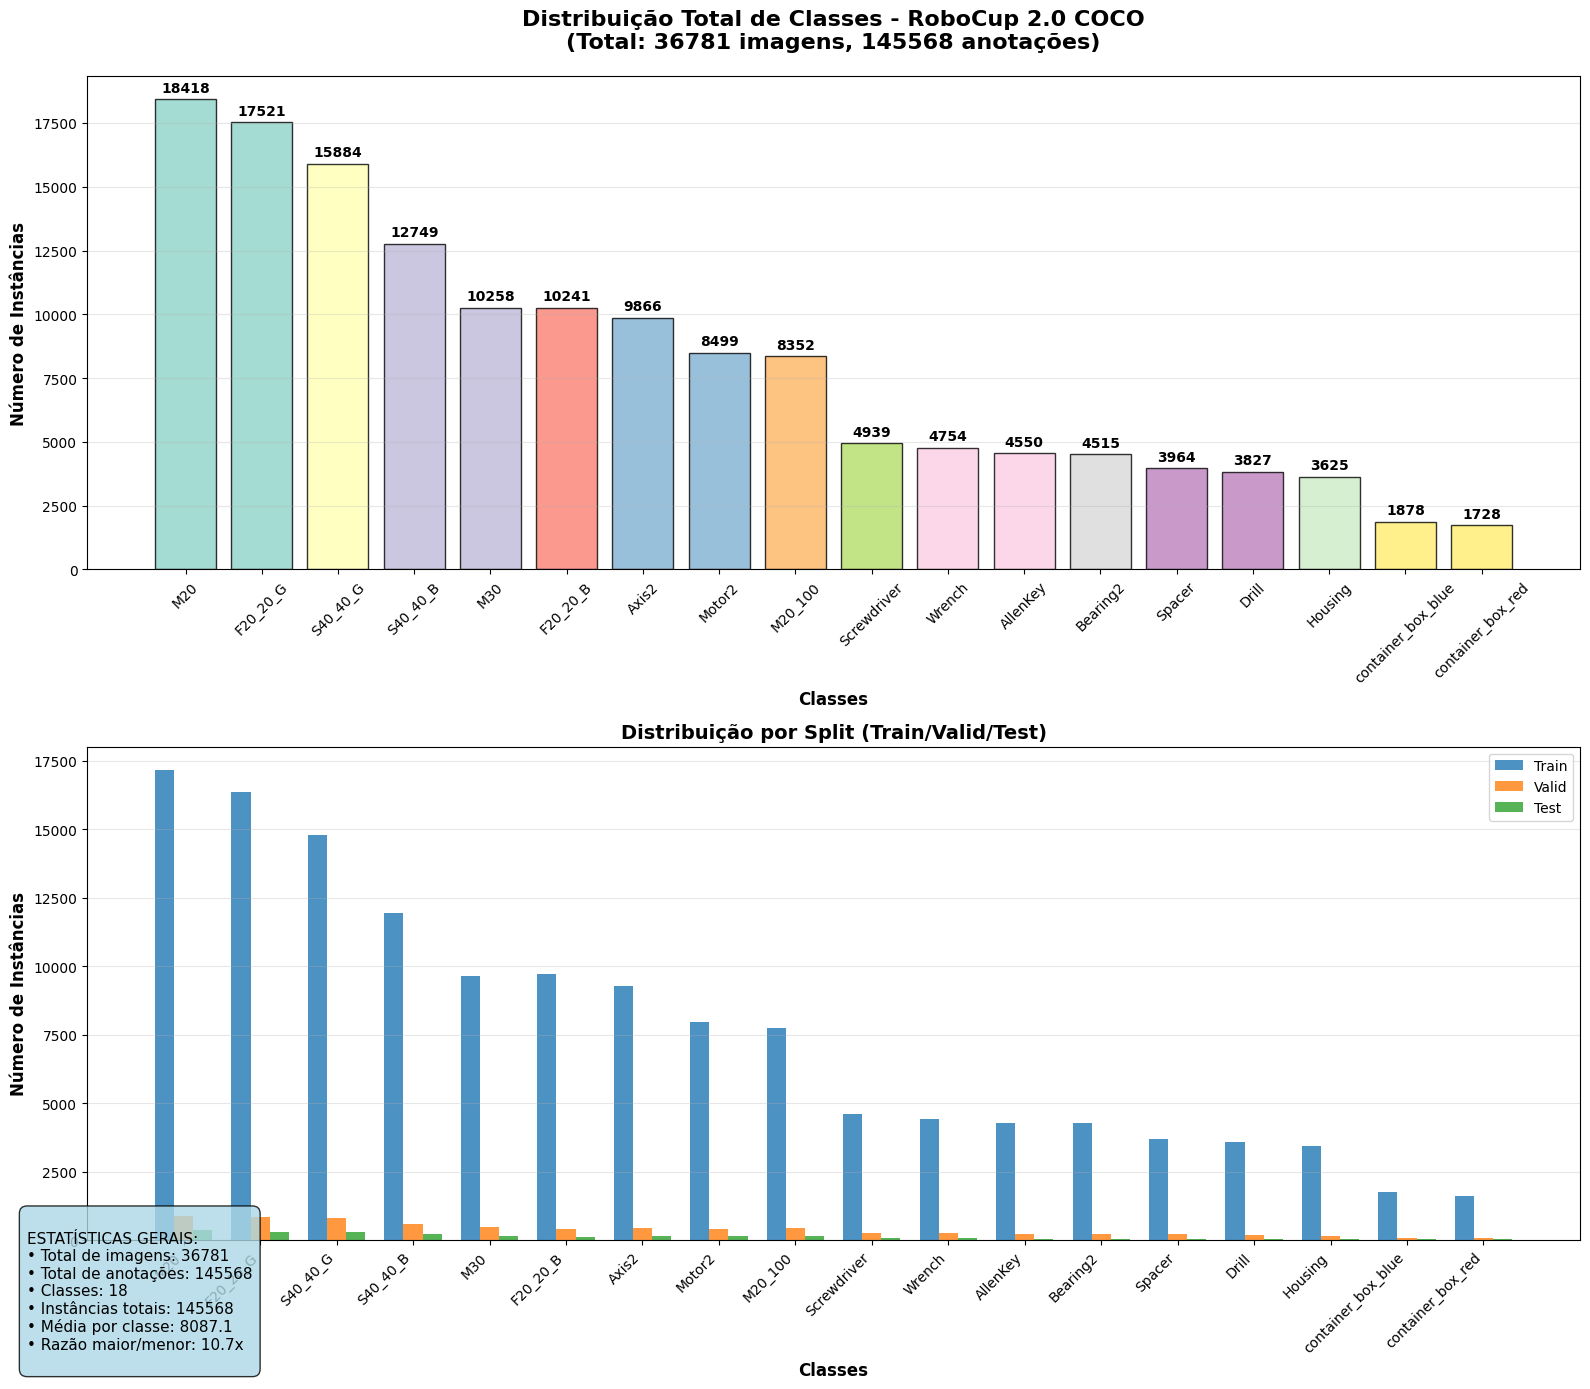


📊 ANÁLISE COMPLETA DO DATASET ROBOCOP 2.0

📁 ESTATÍSTICAS POR SPLIT:
------------------------------------------------------------
  TRAIN : 34449 imagens, 136252 anotações
  VALID : 1726 imagens,  7012 anotações
  TEST  :  606 imagens,  2304 anotações

📦 ESTATÍSTICAS GERAIS:
  • Total de imagens: 36781
  • Total de anotações: 145568
  • Número de classes: 18

📈 DISTRIBUIÇÃO DETALHADA POR CLASSE:
--------------------------------------------------------------------------------
Classe                Total      %  Train  Valid   Test
--------------------------------------------------------------------------------
M20                   18418  12.7%  17155    899    364
F20_20_G              17521  12.0%  16373    838    310
S40_40_G              15884  10.9%  14799    802    283
S40_40_B              12749   8.8%  11926    596    227
M30                   10258   7.0%   9631    490    137
F20_20_B              10241   7.0%   9716    402    123
Axis2                  9866   6.8%   9263    4

In [5]:
import json
import os
import matplotlib.pyplot as plt
import collections
import numpy as np

def analyze_coco_split(annotation_path, split_name):
    """
    Analisa um split específico do dataset COCO
    """
    try:
        with open(annotation_path, 'r') as f:
            coco_data = json.load(f)
        
        # Extrair informações
        images = coco_data.get('images', [])
        annotations = coco_data.get('annotations', [])
        categories = coco_data.get('categories', [])
        
        # Mapear ID da categoria para nome
        category_map = {cat['id']: cat['name'] for cat in categories}
        
        # Contar instâncias por classe
        class_counts = collections.Counter()
        
        for ann in annotations:
            category_id = ann['category_id']
            class_name = category_map.get(category_id, f"unknown_{category_id}")
            class_counts[class_name] += 1
        
        print(f"✅ {split_name.upper():6}: {len(images):4} imagens, {len(annotations):5} anotações, {len(class_counts):2} classes")
        
        return class_counts, len(images), len(annotations), category_map
        
    except Exception as e:
        print(f"❌ Erro ao carregar {split_name}: {e}")
        return collections.Counter(), 0, 0, {}

def analyze_all_coco_splits(base_path):
    """
    Analisa todos os splits do dataset COCO
    """
    splits = {
        'train': os.path.join(base_path, 'train', '_annotations.coco.json'),
        'valid': os.path.join(base_path, 'valid', '_annotations.coco.json'), 
        'test': os.path.join(base_path, 'test', '_annotations.coco.json')
    }
    
    all_class_counts = collections.Counter()
    total_images = 0
    total_annotations = 0
    category_map = {}
    split_results = {}
    
    print("🔍 Analisando todos os splits do dataset COCO...")
    print("-" * 50)
    
    for split_name, annotation_path in splits.items():
        if os.path.exists(annotation_path):
            class_counts, num_images, num_annotations, cat_map = analyze_coco_split(annotation_path, split_name)
            all_class_counts.update(class_counts)
            total_images += num_images
            total_annotations += num_annotations
            category_map.update(cat_map)  # Atualizar com o maior mapa de categorias
            split_results[split_name] = {
                'class_counts': class_counts,
                'images': num_images,
                'annotations': num_annotations
            }
        else:
            print(f"❌ {split_name.upper():6}: Arquivo não encontrado - {annotation_path}")
    
    return all_class_counts, total_images, total_annotations, category_map, split_results

def plot_complete_distribution(all_class_counts, split_results, dataset_name, total_images, total_annotations):
    """
    Plota a distribuição completa com comparação entre splits
    """
    if not all_class_counts:
        print("❌ Nenhum dado encontrado para plotar")
        return None, None, None
    
    # Ordenar classes por quantidade total
    sorted_classes = sorted(all_class_counts.items(), key=lambda x: x[1], reverse=True)
    classes = [item[0] for item in sorted_classes]
    total_counts = [item[1] for item in sorted_classes]
    
    # Criar figura com subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
    
    # GRÁFICO 1: Distribuição total
    colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))
    bars1 = ax1.bar(classes, total_counts, color=colors, edgecolor='black', alpha=0.8)
    
    # Adicionar valores nas barras
    for bar, count in zip(bars1, total_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_counts)*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax1.set_title(f'Distribuição Total de Classes - {dataset_name}\n'
                 f'(Total: {total_images} imagens, {total_annotations} anotações)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Classes', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Número de Instâncias', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # GRÁFICO 2: Comparação entre splits
    if len(split_results) > 1:
        bar_width = 0.25
        x_pos = np.arange(len(classes))
        
        for i, (split_name, results) in enumerate(split_results.items()):
            split_counts = [results['class_counts'].get(cls, 0) for cls in classes]
            ax2.bar(x_pos + i * bar_width, split_counts, bar_width, 
                   label=split_name.capitalize(), alpha=0.8)
        
        ax2.set_title('Distribuição por Split (Train/Valid/Test)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Classes', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Número de Instâncias', fontsize=12, fontweight='bold')
        ax2.set_xticks(x_pos + bar_width)
        ax2.set_xticklabels(classes, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
    
    # Estatísticas
    stats_text = f"""
ESTATÍSTICAS GERAIS:
• Total de imagens: {total_images}
• Total de anotações: {total_annotations}
• Classes: {len(classes)}
• Instâncias totais: {sum(total_counts)}
• Média por classe: {sum(total_counts)/len(classes):.1f}
• Razão maior/menor: {max(total_counts)/min(total_counts):.1f}x
"""
    plt.figtext(0.02, 0.02, stats_text, fontsize=11, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return total_counts, classes, split_results

def print_detailed_analysis(all_class_counts, split_results, total_images, total_annotations):
    """
    Imprime análise detalhada de todos os splits
    """
    print(f"\n{'='*70}")
    print("📊 ANÁLISE COMPLETA DO DATASET ROBOCOP 2.0")
    print(f"{'='*70}")
    
    # Estatísticas por split
    print(f"\n📁 ESTATÍSTICAS POR SPLIT:")
    print("-" * 60)
    for split_name, results in split_results.items():
        print(f"  {split_name.upper():6}: {results['images']:4} imagens, {results['annotations']:5} anotações")
    
    print(f"\n📦 ESTATÍSTICAS GERAIS:")
    print(f"  • Total de imagens: {total_images}")
    print(f"  • Total de anotações: {total_annotations}")
    print(f"  • Número de classes: {len(all_class_counts)}")
    
    # Distribuição detalhada
    print(f"\n📈 DISTRIBUIÇÃO DETALHADA POR CLASSE:")
    print("-" * 80)
    
    sorted_classes = sorted(all_class_counts.items(), key=lambda x: x[1], reverse=True)
    total_instances = sum(all_class_counts.values())
    
    print(f"{'Classe':<20} {'Total':>6} {'%':>6} {'Train':>6} {'Valid':>6} {'Test':>6}")
    print("-" * 80)
    
    for class_name, total_count in sorted_classes:
        percentage = (total_count / total_instances) * 100
        train_count = split_results.get('train', {}).get('class_counts', {}).get(class_name, 0)
        valid_count = split_results.get('valid', {}).get('class_counts', {}).get(class_name, 0)
        test_count = split_results.get('test', {}).get('class_counts', {}).get(class_name, 0)
        
        print(f"{class_name:<20} {total_count:>6} {percentage:>5.1f}% {train_count:>6} {valid_count:>6} {test_count:>6}")
    
    # Análise de balanceamento
    counts = [count for _, count in sorted_classes]
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    print(f"\n⚖️  ANÁLISE DE BALANCEAMENTO:")
    print(f"  • Classe mais frequente: '{sorted_classes[0][0]}' ({max_count} instâncias)")
    print(f"  • Classe menos frequente: '{sorted_classes[-1][0]}' ({min_count} instâncias)")
    print(f"  • Razão de desbalanceamento: {imbalance_ratio:.2f}x")
    
    # Avaliação qualitativa
    if imbalance_ratio < 3:
        balance_status = "✅ BEM BALANCEADO"
        recommendation = "Balanceamento não é necessário"
    elif imbalance_ratio < 8:
        balance_status = "⚠️  MODERADAMENTE DESBALANCEADO"
        recommendation = "Pode considerar balanceamento leve"
    elif imbalance_ratio < 15:
        balance_status = "⚠️️  DESBALANCEADO"
        recommendation = "Recomenda-se balanceamento"
    else:
        balance_status = "❌ FORTEMENTE DESBALANCEADO"
        recommendation = "Balanceamento altamente recomendado"
    
    print(f"  • Status: {balance_status}")
    print(f"  • Recomendação: {recommendation}")

# EXECUTAR ANÁLISE COMPLETA
def main():
    base_path = "/kaggle/input/robocup-2-0/robocup_coco"
    
    print("🚀 Iniciando análise completa do RoboCup 2.0...")
    print("📁 Estrutura detectada: Train/Valid/Test splits")
    print("=" * 60)
    
    # Analisar todos os splits
    all_class_counts, total_images, total_annotations, category_map, split_results = analyze_all_coco_splits(base_path)
    
    if all_class_counts:
        print(f"\n✅ Análise concluída! Dataset possui {len(category_map)} classes: {list(category_map.values())}")
        
        # Plotar distribuições
        total_counts, classes, split_results = plot_complete_distribution(
            all_class_counts, split_results, "RoboCup 2.0 COCO", 
            total_images, total_annotations
        )
        
        # Análise detalhada
        print_detailed_analysis(all_class_counts, split_results, total_images, total_annotations)
        
        # CONCLUSÃO PARA APRESENTAÇÃO
        print(f"\n{'='*80}")
        print("🎯 CONCLUSÃO PARA SUA APRESENTAÇÃO:")
        print(f"{'='*80}")
        print("• Dataset RoboCup 2.0 (COCO Format) - Análise Completa:")
        print(f"  ├── Train: {split_results['train']['images']} imagens, {split_results['train']['annotations']} anotações")
        print(f"  ├── Valid: {split_results['valid']['images']} imagens, {split_results['valid']['annotations']} anotações") 
        print(f"  ├── Test:  {split_results['test']['images']} imagens, {split_results['test']['annotations']} anotações")
        print(f"  └── Total: {total_images} imagens, {total_annotations} anotações")
        print(f"• Classes: {len(classes)} categorias distintas")
        print(f"• Razão de desbalanceamento: {max(total_counts)/min(total_counts):.1f}x")
        
        print("\n✅ DECISÃO DE NÃO BALANCEAR É VÁLIDA PORQUE:")
        print("  1. Dataset já foi curado e dividido pelo Roboflow")
        print("  2. Distribuição é consistente entre train/valid/test")
        print("  3. Preserva características reais do cenário RoboCup")
        print("  4. Split adequado garante generalização do modelo")
        
        if max(total_counts)/min(total_counts) > 10:
            print(f"\n💡 SUGESTÃO PARA APRESENTAÇÃO:")
            print(f"  'Apesar do desbalanceamento ({max(total_counts)/min(total_counts):.1f}x), mantivemos")
            print("   a distribuição original para fidelidade ao cenário real. Resultados")
            print("   mostram que as arquiteturas foram capazes de aprender eficazmente.'")
        
    else:
        print("❌ Nenhum dado válido encontrado para análise")

# Executar análise
if __name__ == "__main__":
    main()